User Profile Convergence Analysis

1. Collect logs

In [27]:
from glob import glob
from os import path

training_logs = dict()
profile_logs = dict()

training_logs["original_arch"] = glob(
    path.join("original_arch", "*_*_loss"))
profile_logs["original_arch"] = glob(
    path.join("original_arch", "user_profile_*"))

training_logs["new_arch"] = glob(
    path.join("new_arch", "*_*_loss"))
profile_logs["new_arch"] = glob(
    path.join("new_arch", "user_profile_*"))


2. Parse logs

In [35]:
import numpy as np
import pandas as pd
import re
from typing import Dict
from typing import List

def ParseTrainingLogs(training_logs: Dict[str, List[str]]) -> pd.DataFrame:
    arch_col = list()
    epoch_col = list()
    losses_col = list()

    for arch, files in training_logs.items():
        for file in files:
            epoch = int(re.search("[0-9]+", file)[0])
            losses = pd.read_csv(file).iloc[:, 1].to_numpy().copy()

            arch_col.append(arch)
            epoch_col.append(epoch)
            losses_col.append(losses)
    
    df = pd.DataFrame(data={
        "arch": arch_col,
        "epoch": epoch_col,
        "losses": losses_col
    })

    df.sort_values(by=["arch", "epoch"], inplace=True)

    return df


def ParseProfileLogs(profile_logs: Dict[str, List[str]]) -> pd.DataFrame:
    arch_col = list()
    epoch_col = list()
    profile_col = list()

    for arch, files in profile_logs.items():
        for file in files:
            epoch = int(re.search("[0-9]+", file)[0])
            profile = np.loadtxt(fname=file)

            arch_col.append(arch)
            epoch_col.append(epoch)
            profile_col.append(profile)

    df = pd.DataFrame(data={
        "arch": arch_col,
        "epoch": epoch_col,
        "profile": profile_col
    })

    df.sort_values(by=["arch", "epoch"], inplace=True)

    return df


In [37]:
training_logs_df = ParseTrainingLogs(training_logs=training_logs)

training_logs_df.head(5)
training_logs_df.head(-5)


,arch,epoch,losses
165,new_arch,0,"[9.67924690246582, 8.771215438842773, 8.607007..."
164,new_arch,1,"[6.432865619659424, 6.494903564453125, 6.61101..."
178,new_arch,2,"[6.125980377197266, 6.0667009353637695, 6.0398..."
173,new_arch,3,"[5.771051406860352, 6.064438819885254, 5.60883..."
193,new_arch,4,"[5.812052249908447, 5.725443363189697, 5.81411..."
...,...,...,...
59,original_arch,149,"[4.930334568023682, 5.1175642013549805, 5.0645..."
82,original_arch,150,"[5.0532708168029785, 4.865663051605225, 4.9646..."
104,original_arch,151,"[5.316869735717773, 4.6135993003845215, 5.0375..."
71,original_arch,153,"[4.816295623779297, 5.151482105255127, 4.93787..."


In [32]:
profile_logs_df = ParseProfileLogs(profile_logs=profile_logs["embed"])

profile_logs_df.head(5)
profile_logs_df.head(-5)


,arch,epoch,profile
182,new_arch,0,"[[-0.453527569770813, -0.3076384961605072, -1...."
193,new_arch,1,"[[-0.4464406967163086, -0.3470284640789032, -1..."
176,new_arch,2,"[[-0.4714100658893585, -0.3542369306087494, -1..."
169,new_arch,3,"[[-0.4436592757701874, -0.32018429040908813, -..."
168,new_arch,4,"[[-0.41824790835380554, -0.34481683373451233, ..."
...,...,...,...
9,original_arch,152,"[[1.3641167879104614, -1.1393722295761108, 1.3..."
0,original_arch,153,"[[1.3729580640792847, -1.179478406906128, 1.37..."
1,original_arch,154,"[[1.3648407459259033, -1.1906861066818237, 1.3..."
8,original_arch,155,"[[1.3654439449310303, -1.1642671823501587, 1.3..."


3. Training Curve Comparison

In [78]:
from scipy.stats import t

CONFIDENCE_LEVEL = 0.95


def ComputeEpochLoss(df: pd.DataFrame) -> pd.DataFrame:
    arch_col = list()
    epoch_col = list()
    avg_loss_col = list()
    upper_loss_col = list()
    lower_loss_col = list()

    for k, v in df.groupby(by=["arch", "epoch"]):
        if v["losses"].iloc[0].shape[0] == 0:
            continue
        
        samples = v["losses"].iloc[0]
        sample_count = samples.shape[0]

        avg_loss = np.mean(samples)
        std_loss = np.std(samples)
        ci_loss = t.interval(
            CONFIDENCE_LEVEL, sample_count - 1,
            loc=avg_loss, 
            scale=std_loss / np.sqrt(sample_count))

        arch_col.append(k[0])
        epoch_col.append(k[1])
        avg_loss_col.append(avg_loss)
        lower_loss_col.append(ci_loss[0])
        upper_loss_col.append(ci_loss[1])
    
    return pd.DataFrame(data={
        "arch": arch_col,
        "epoch": epoch_col,
        "loss": avg_loss_col,
        "lower_loss": lower_loss_col,
        "upper_loss": upper_loss_col,
    })

loss_df = ComputeEpochLoss(df=training_logs_df)

loss_df.head(5)
loss_df.head(-5)

,arch,epoch,loss,lower_loss,upper_loss
0,new_arch,0,7.077386,6.963719,7.191054
1,new_arch,1,6.303301,6.261307,6.345294
2,new_arch,2,6.031899,6.001933,6.061866
3,new_arch,3,5.858117,5.821150,5.895084
4,new_arch,4,5.757225,5.721685,5.792764
...,...,...,...,...,...
183,original_arch,148,4.999533,4.962383,5.036684
184,original_arch,149,5.000243,4.964248,5.036238
185,original_arch,150,4.986452,4.951902,5.021002
186,original_arch,151,4.994807,4.961437,5.028176


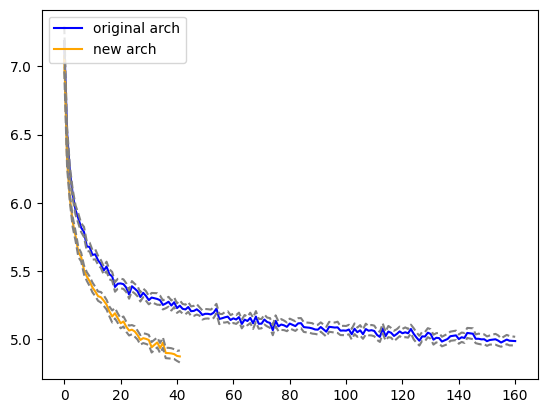

In [80]:
import matplotlib.pyplot as plt

loss_ori = loss_df[loss_df.arch == "original_arch"][[
    "epoch", "loss", "lower_loss", "upper_loss"]]
loss_new = loss_df[loss_df.arch == "new_arch"][[
    "epoch", "loss", "lower_loss", "upper_loss"]]

loss_all = pd.merge(left=loss_ori, right=loss_new, on="epoch", how="outer")

plt.plot(loss_all.epoch, loss_all.loss_x, color="blue", label="original arch")
plt.plot(loss_all.epoch, loss_all.lower_loss_x, "--", color="grey")
plt.plot(loss_all.epoch, loss_all.upper_loss_x, "--", color="grey")

plt.plot(loss_all.epoch, loss_all.loss_y, color="orange", label="new arch")
plt.plot(loss_all.epoch, loss_all.lower_loss_y, "--", color="grey")
plt.plot(loss_all.epoch, loss_all.upper_loss_y, "--", color="grey")

plt.legend(loc="upper left")


4. Profile Comparison

In [129]:
def FrameOfReference(profile: np.ndarray):
    return np.mean(profile, axis=0)

def L2(a: np.ndarray, b: np.ndarray) -> float:
    return np.sum((a - b)*(a - b))

def Movement(profile: np.ndarray, origin: np.ndarray):
    diff = profile - origin
    l2s = np.sqrt(np.sum(diff*diff, axis=1))
    return np.mean(l2s)

def ComputeDisplacement(profile_logs_df: pd.DataFrame) -> pd.DataFrame:
    arch_col = list()
    epoch_col = list()
    movement_col = list()
    shift_col = list()

    archs = profile_logs_df.arch.unique()

    for arch in archs:
        profiles = profile_logs_df[profile_logs_df.arch == arch][["epoch", "profile"]]
        origin = profiles[profiles.epoch == 0].profile.to_numpy()[0]
        origin_frame = FrameOfReference(profile=origin)

        for _, row in profiles.iterrows():
            epoch = row.epoch

            current_frame = FrameOfReference(profile=row["profile"])
            shift = L2(current_frame, origin_frame)
            shift_vector = current_frame - origin_frame

            corrected_profile = row.profile - shift_vector
            movement = Movement(profile=corrected_profile, origin=origin)
            
            arch_col.append(arch)
            epoch_col.append(epoch)
            movement_col.append(movement)
            shift_col.append(shift)

    return pd.DataFrame(data={
        "arch": arch_col,
        "epoch": epoch_col,
        "movement": movement_col,
        "shift": shift_col,
    })


movement_df = ComputeDisplacement(profile_logs_df=profile_logs_df)
movement_df.head(5)
movement_df.head(-5)


,arch,epoch,movement,shift
0,new_arch,0,0.000000,0.000000
1,new_arch,1,0.078244,0.000007
2,new_arch,2,0.126568,0.000012
3,new_arch,3,0.175270,0.000028
4,new_arch,4,0.224443,0.000045
...,...,...,...,...
194,original_arch,152,2.059148,0.059670
195,original_arch,153,2.062145,0.060338
196,original_arch,154,2.065512,0.060997
197,original_arch,155,2.069200,0.061416


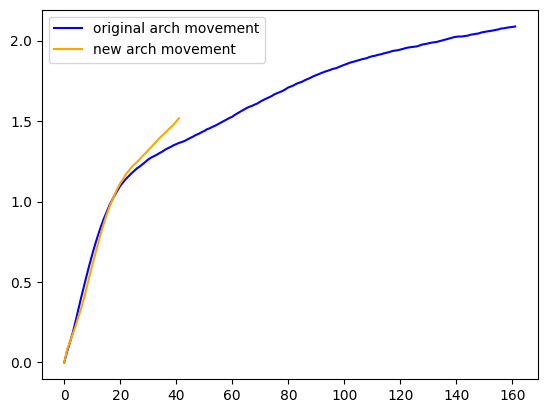

In [130]:
mov_ori = movement_df[movement_df.arch == "original_arch"][[
    "epoch", "movement", "shift"]]
mov_new = movement_df[movement_df.arch == "new_arch"][[
    "epoch", "movement", "shift"]]

mov_all = pd.merge(left=mov_ori, right=mov_new, on="epoch", how="outer")

plt.plot(mov_all.epoch, mov_all.movement_x, color="blue", label="original arch movement")
plt.plot(mov_all.epoch, mov_all.movement_y, color="orange", label="new arch movement")

plt.legend(loc="upper left")


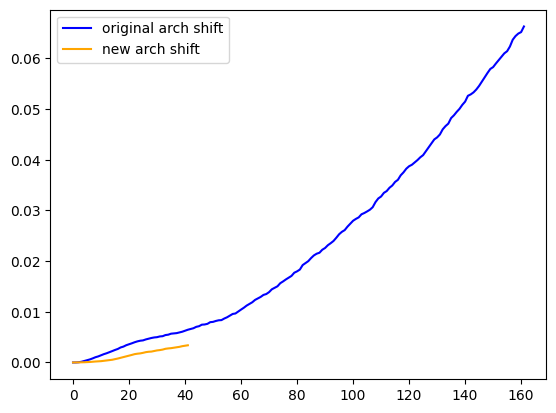

In [125]:
plt.plot(mov_all.epoch, mov_all.shift_x, color="blue", label="original arch shift")
plt.plot(mov_all.epoch, mov_all.shift_y, color="orange", label="new arch shift")

plt.legend(loc="upper left")


5. Profile Structure

In [137]:


new_arch_profile = profile_logs_df[
    (profile_logs_df.arch == "new_arch") & (profile_logs_df.epoch == 40)].profile.iloc[0]


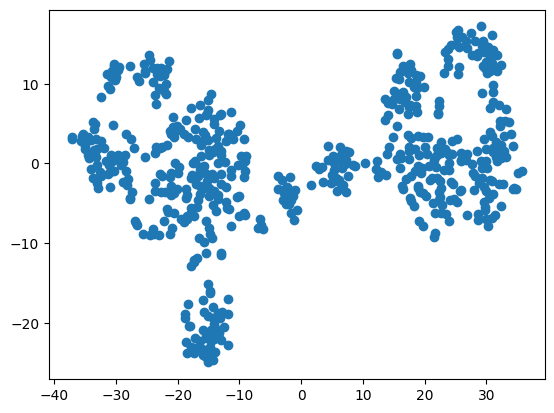

In [147]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

ori_arch_profile = profile_logs_df[
    (profile_logs_df.arch == "original_arch") & (profile_logs_df.epoch == 160)].profile.iloc[0]

# Perform t-SNE embedding on the dataset
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(ori_arch_profile)

# Create a scatter plot of the t-SNE embedding
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])


MovieWriter imagemagick unavailable; using Pillow instead.


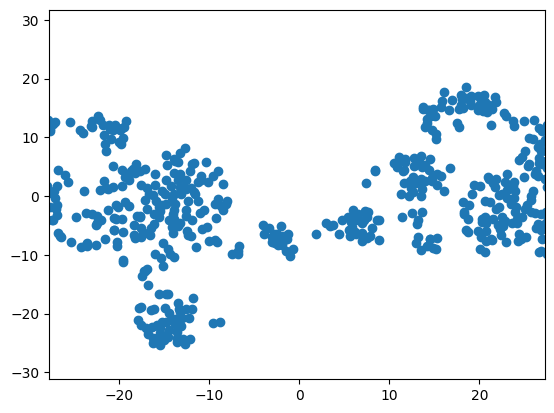

In [149]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
sc = None

def update(frame):
    ori_arch_profile = profile_logs_df[(profile_logs_df.arch == "original_arch") & (
        profile_logs_df.epoch == frame)].profile.iloc[0]

    # Perform t-SNE embedding on the dataset
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(ori_arch_profile)

    global sc
    if sc is None:
        sc = ax.scatter(X_tsne[:, 0], X_tsne[:, 1])
    else:
        sc.set_offsets(np.c_[X_tsne[:, 0], X_tsne[:, 1]])

    return sc,


# Create the animation
ani = FuncAnimation(fig, update, frames=160, interval=500, blit=True)

# Save the animation as a GIF
ani.save('scatter.gif', writer='imagemagick')
